----------------
# Image Based Mechanics - hands-on session 1: FE-DIC
## October, 6 - 10, 2025, CISM, Udine, Italy
#### Jean-Charles PASSIEUX, ICA/INSA Toulouse
----------------
#### We consider an openhole glass/epoxy coupon subjected to a tensile test. A set of images was taken before and during the experiment. For more details about the experiment, please refer to reference below.

#### In this session, you see how to **perform FE-DIC**, try **different multiscale initializations**, observe the effect of the mesh and the speckle on **measurement uncertainties**, analyse the **graylevel residuals** and implement different timeline resolution strategies.

[JC. Passieux, F. Bugarin, C. David, J. Périé and L. Robert (2015)](http://dx.doi.org/10.1007/s11340-014-9872-4) **Multiscale displacement field measurement using digital image correlation: Application to the identification of elastic properties** _Experimental Mechanics_ 55(1), p.121-137

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyxel as px

## 1. Images
### Open and plot images

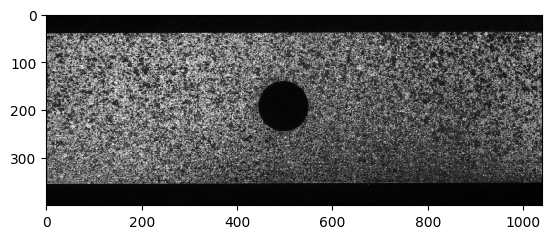

In [10]:
filename = 'oht_cfrp_%02d.tiff'
I0 = px.Image(filename % 0).Load()
I0.Plot()

### Plot initial residual

In [ ]:
I10 = px.Image(filename % 10).Load()
plt.imshow(I0.pix - I10.pix, cmap='RdBu')
plt.colorbar()

### Evaluation of image noise

In [18]:
roi = np.array([[ 476, 162], [525, 222]])
Iroi = I0.pix[roi[0, 1]:roi[1, 1], roi[0, 0]:roi[1, 0]]
fall = np.zeros((Iroi.shape[0], Iroi.shape[1], 11))
fall[:, :, 0] = Iroi
for i in range(1, 11):
    It = px.Image(filename % i).Load()
    fall[:, :, i] = It.pix[roi[0, 1]:roi[1, 1], roi[0, 0]:roi[1, 0]]

sigf = np.mean(np.std(fall, axis=2))
print("Estimation of image noise in graylevels = %1.5f" % sigf)

Estimation of image noise in graylevels = 0.99870


## 2. Mesh

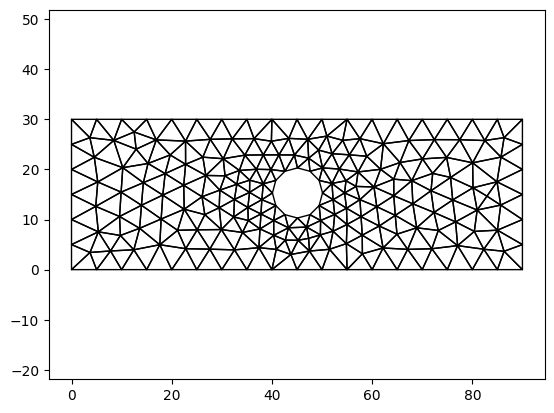

In [35]:
box = np.array([[0, 0], [90, 30]])   # outerbox
r = 5                                # hole radius
cpos = np.array([45.1, 15.3])        # position of the hole center
lc = 5                               # size of the elements close the outer boundary
lf = 3                               # size of the elements close to the hole
m = px.OpenHolePlateUnstructured(box, r, cpos, lc, lf)
m.Plot()

## 3. Camera model

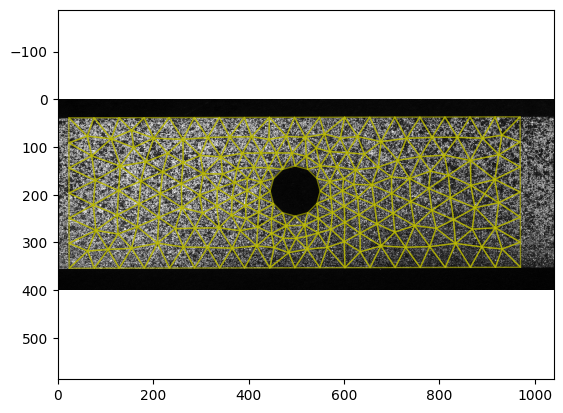

In [23]:
cam = px.Camera(2)
p = np.array([-0.002176, 2.237317, 33.687119, 9.51087e-02])
cam.set_p(p)    
px.PlotMeshImage(I0, m, cam)

## 4. Run FE-DIC

#### Perform FE-DIC without initialization and comment on the convergence of the algorithm

In [ ]:
m.Connectivity()
m.DICIntegration(cam)
U, res = px.Correlate(I0, It, m, cam)

#### Try to use `px.MultiscaleInit()` or `px.DISFlowInit()` initializations functions and run again `Correlate`

In [ ]:
U0 = px.MultiscaleInit(I0, It, m, cam, scales=[3, 2, 1])
U, res = px.Correlate(I0, It, m, cam, U0=U0)

## 5. Plot the results
#### Try different postprocessing functions to plot displacement and strain fields

In [ ]:
m.Plot(edgecolor='#CCCCCC')
m.Plot(U, 30)

In [ ]:
m.PlotContourDispl(U, s=30)

In [ ]:
m.PlotContourStrain(U, clim=1, cmap='RdBu')

In [ ]:
px.PlotMeshImage(It, m, cam, U, plot='displ')

#### **Exercise:** refine the mesh and observe the evolution of the displacement regularity

## 6. A priori uncertainty quantification
#### Remainder: the covariance of the displacement reads:
$$ \textrm{Cov}_u = 2\ \sigma_I\ \mathbf H^{-1}_{\textrm{DIC}}$$

In [ ]:
dic = px.DICEngine()
H = dic.ComputeLHS(I0, m, cam)
Cov = np.linalg.inv(H.toarray())
diag = 2 * sigf * np.sqrt(np.diag(Cov))
m.PlotContourDispl(diag, s=0, stype='mag')

#### **Exercise:** refine the mesh and observe the evolution of the a priori uncertainty

## 7. Analyse graylevel residual
#### Use the functions below to plot the graylevel residual

In [ ]:
emp = px.ExportPixMap(I0, m, cam)
Rmap = emp.PlotResidual(I0, It, U)

#### **Exercise:** compare initial ($U=0$) residual with converged residual

## 8. FE-DIC measurement over time
#### Use the displacements measured at the previous time steps to better initialize the Gauss-Newton solver

In [ ]:
UU = np.zeros((m.ndof, 11))
for i in range(1, 11):
    It = px.Image(filename % i).Load()
    U0 = #TODO
    U, res = px.Correlate(I0, It, m, cam, U0=U0)
    UU[:, i] = U

In [ ]:
for i in range(1, 11):
    m.Plot(UU[:, i], s=30)

#### **Exercise.** Improve the iteration using linear prediction.